<h1><center>Graded practical work (12h)</center></h1>

William Angelier et Marine de Fontenay

# INTRODUCTION

### Objective

Set up a simple yet effective POMDP model in order to drive human-machine interaction in the Firefighter Robot Game study case. This POMDP model will be based on a dataset that has been collected during an experiment and that is provided to you.

### Recall: the POMDP model

Let's recall that a POMDP (Partially Observable Markov Decision Process) is a tuple $\langle S, A, \Omega, p(), o(), r(), b_0 \rangle$, with $S$ (resp. $A$, $\Omega$) the state (resp. action, observation) space.
How does this probabilistic planning model work?
1. At each time step $t \in \mathbb{N}$, the artificial agent has only a partial knowledge of the actual current state $s \in S$. In order to still be able to reason about the state of the system, the agent maintains a probability distribution over $S$, called belief state, and denoted by $b_t$. The initial belief state is $b_0$ and takes part in the definition of the POMDP as a prior distribution about the initial state.
2. When the artificial agent selects an action $a \in A$, the probability that the state of the system switches from $s \in S$ to $s' \in S$, is $Pr(s'\mid s,a) = p(s,a,s')$ given by the transition probability function $p()$ in the POMDP definition.
3. The current state is not available to the artificial agent, but the latter still receives information given by the observation $o' \in \Omega$. The probability that the observation $o' \in \Omega$ is received, is $Pr(o'\mid s',a) = o(a,s',o')$ given by the observation probability function $o()$. 
4. An action $a$ applied in a state $s$ is rewarded by $r(s,a) \in \mathbb{R}$ given by the reward function $r()$.

![POMDP_for_HRI.png](attachment:POMDP_for_HRI.png)


#### The belief state:
1. In partially observable domains, only successive actions and observations are visible to the agent to implement the state estimation. These sequences can be seen as the agent's memory.
2. Let's define the history of all observations received and actions performed at time step $t \in \mathbb{N}$: $h_t := \{a_0, o_1,...,o_{t-1},a_{t-1},o_t\}$. The size of the history grows with the time step $t \in \mathbb{N}$, so it can become huge very quickly.
3. The definition of the belief state at time step $t \in \mathbb{N}$ is the probability of the current state $s_t \in S$ given the history $h_t$: $b_t(s) = Pr(s_t = s \mid h_t)$.

However, in practice, it is not necessary to keep the history in memory to compute the belief state. It is indeed possible to simply update the previous belief state using the action performed, and the observation received:
\begin{eqnarray*}
{b_{t+1}(s')} & = & Pr(s' \mid h_{t+1}) = Pr(s' \mid  h_t, a_t, o_{t+1})
 = \dfrac{Pr(o_{t+1},s' \mid h_t,a_t)}{Pr(o_{t+1} \mid h_t,a_t)} \nonumber \\
& = & \dfrac{Pr(o_{t+1} \mid s', a_t) Pr(s' \mid h_t,a_t) }{Pr(o_{t+1} \mid h_t, a_t)} 
= \dfrac{o(a_t, s', o_{t+1}) Pr(s' \mid h_t,a_t) }{Pr(o_{t+1} \mid h_t,a_t)} \nonumber \\
& = & \dfrac{ o(a_t, s', o_{t+1}) \sum_{s \in S} Pr(s' \mid s, a_t) Pr(s \mid h_t) }{ Pr(o_{t+1} \mid h_t,a_t)} 
= \dfrac{ o(a_t, s', o_{t+1}) \sum_{s \in S}p(s,a_t,s') b_t(s) }{ Pr(o_{t+1} \mid h_t,a_t)} \nonumber \\
& = & \dfrac{ o(a_t, s', o_{t+1}) \sum_{s \in S}p(s,a_t,s') b_t(s) }{ \sum_{(s,s') \in S^2} o(a_t, s', o_{t+1}) p(s,a_t,s') b_t(s) } \nonumber = U(b_t,a_t,o_{t+1})(s').
%{b_o^a(s')} & = & p(s' \mid b,a,o) = \dfrac{p(o,s' \mid b,a)}{p(o \mid b,a)} \nonumber \\
%& = &\dfrac{p(o \mid s',a)p(s' \mid b,a)}{p(o \mid b,a)}\nonumber \\
%& = &\dfrac{p(o \mid s',a)p(s' \mid b,a)}{\sum_{s,s'}p(o \mid b,a,s,s')p(s,s'\mid b,a)}\nonumber\\
%& = &\dfrac{p(o \mid s',a)\sum_{s\in S} p(s' \mid s,a)b(s)
%}{\sum_{s'\in S}p(o \mid s',a)\sum_{s\in S} p(s'\mid s,a)b(s)}
\label{beliefupdate}
\end{eqnarray*}
The belief update function $U$ can be defined using transition and observation functions $p()$ and $o()$. When the artificial agent uses action $a_t$ and receives observation $o_{t+1}$, it can use $b_{t+1} = U(a_t,o_{t+1},b_t)$ as belief on the system state $s_{t+1}$. Now, if the belief state is $b_t$, and the selected action is $a_t$, the probability of obtaining the belief state $b_{t+1} = U(b_t,a_t,o_{t+1})$ is the following:
\begin{eqnarray*}
Pr(o_{t+1} \mid  h_t, a_t) & = & \sum_{s' \in S} Pr(o_{t+1} \mid s', a_t) Pr(s' \mid h_t) = \sum_{(s,s') \in S^2} Pr(o_{t+1} \mid s', a_t) Pr(s' \mid s, a_t) Pr(s \mid h_t)\\ 
& = & \sum_{(s,s') \in S^2} o(a_t, s', o') p(s, a_t, s') b_t(s).
\end{eqnarray*}
Since the probability distribution on the next belief $b_{t+1}$ only depends on the previous belief $b_t$ and the current action $a_t$, the belief state process $(b_t)_{t \in \mathbb{N}}$ is a Markov Decision Process (MDP) whose system space is the space of probability distributions. As a result, a POMDP can be transformed into a belief state MDP.

In short, the artificial agent synthesizes all available information from the past using a belief state $b_t(s)$, which is a probability distribution on the system state updated every time step: $b_t(s) := Pr(s_t=s|o_t,a_{t-1},o_{t-1},..., a_0) = U(a_{t-1},o_t,b_{t-1})(s)$.

#### POMDP solving objective

The agent's objective is to choose actions that will drive him to achieve better rewards. Let's define a deterministic Markovian policy $\pi(b)$ as a function such as, $\pi (b): b\mapsto a$. The expected value of a given action policy $\pi (b)$ can be formilized as:

$V^{\pi}(b) = E_\pi\left[\sum ^{\infty} _{t=0} \gamma ^{t} r(b_t,\pi(b_t)) \middle\vert b_0=b\right]$

where,  $0 \leqslant \gamma < 1$, and $r(b_t,\pi(b_t))=\sum_{s\in S}r(s,\pi(b_t))b_t(s)$

In the POMDP context, we search for the optimal policy $\pi^*(b)$ that maximizes the expectation of *the sum of discounted rewards* ($\gamma$-discounted criteron). 

$V^{\pi^*}(b) = \max_\pi E_\pi\left[\sum ^{\infty} _{t=0} \gamma ^{t} r(b_t,\pi(b_t)) \middle\vert b_0=b\right]$

Opening the sum above, on can retrieve the Bellman equation:

$V^{\pi^*}(b)  =  \max_{a\in A } \left[ \sum_{s\in S}r(s,a)b(s) + \gamma\sum_{o \in \Omega} p(o|a,b)V^{\pi^*}(b^a_o)\right]$

Thus, an optimal policy $\pi^*$ is defined by $V^{\pi^*}$ that satisfies this Bellman. The solution is said optimal when $V^*=V^{\pi^*}$ converges to a fixed point for any $b$. In other words, one could iterate on this value function $\forall b$ until it converges, and then extract the related policy.

However:
1. the exact solution in infinite horizon settings is *hard* to compute (PSPACE-complete)
2. actually, current algorithms approach the optimal solution, exploiting particular properties: of the value function and of the system dynamics.


#### Value Function parametrization

1. The infinite horizon value function $V^{\pi}(b) = E_{\pi}\left[\sum ^{\infty} _{t=0} \gamma ^{t} r(b_t,\pi(b_t)) \middle\vert b_0=b\right]$ can be approximated by the finite horizon optimal value function $V^{\pi}(b) = E_{\pi}\left[\sum ^{N} _{t=0} r(b_t,\pi(b_t)) \middle\vert b_0=b\right]$ which is a piece-wise linear and convex (PWLC) function.

2. If the function $F: \mathbb{R}^{S} \rightarrow \mathbb{R}$ is a PWLC function,
it exists a finite set of vectors of $\mathbb{R}^{S}$,
denoted by $\{ \alpha_i \}_{i=1}^n$, such that $F$ can be written 
$F(b) = \displaystyle \max_{i=1}^n \alpha_i \cdot b = \max_{i=1}^n \sum_{s \in S} \alpha_{i}(s) \cdot b(s)$.
Since the belief state $b$ is a probability distribution over $S$, 
we can write $b: S \rightarrow [0,1]$, and even $b \in \mathbb{R}^S$. 
The approximation of the optimal value function 
$V: \mathbb{R}^S \rightarrow \mathbb{R}$ 
can be parameterized by a set of $\alpha$-vectors
$\Gamma_n = \left\lbrace \alpha_i \right\rbrace_{i=1}^n$, with $\alpha_i \in \mathbb{R}^S$, $\forall i$.
Indeed,
$V(b) = \displaystyle \max_{\alpha \in \Gamma_n} \alpha \cdot b = \max_{\alpha \in \Gamma_n} \sum_{s \in S} \alpha(s) \cdot b(s)$.
$%i \in 1,...,|V_n|$
3. In fact, $V$ is defined on the belief space
$\{ b \in \mathbb{R}^S \mid \sum_s b(s)=1 \}$.
Each $\alpha$-vector $\alpha_i \in \mathbb{R}^S$
is associated with an action $a(\alpha) \in A$,
and defines a region of the belief space, 
where $\alpha_i \cdot b = \max_j \alpha_j \cdot b = V(b)$,
that is, where $\alpha_i \cdot b$ reaches is maximum.
The $\alpha$-vectors form then a partition of the belief state.

$$%V_n(b)  =  \max _{\alpha ^i_n \in \Gamma_n} \sum _{s \in S} b(s)\alpha ^i_n(s) \rightarrow V_n(b)  =  \max_{\alpha ^i_n \in \Gamma_n}b\cdot \alpha _n^i$$ 

Thus, for a given belief state $b$, the gradient of the value function is induced by the vector:

$$ \alpha^b = \operatorname*{arg\,max}_{\alpha \in \Gamma_n} b \cdot \alpha $$

and, the associated policy $\pi(b) \in A$ is the action of this $\alpha$-vector, that is: 
$\pi(b) = a(\alpha^b)$. 

#### Solving Algorithm : point-based value iteration  (PBVI)

#### Value backup operation:
Let's define a $V_n$ parameterized by a set $\Gamma_n$ of $\alpha$-vectors and a given belief state $b$. One can compute $\alpha^b_{n+1}$ of $V_{n+1}$ from $LV_n$ (the unknown set of vectors):
$\alpha _{n+1}^b = arg\max_{\alpha _{n+1}^i \in \mathcal{L}V_n} b \cdot \alpha _{n+1}^i,$

Let's define $r_a=r(s,a)$ and $b \cdot r_a = \sum_s b(s)r(s,a)$, and a set of belief states $\mathcal B$ where $b\in \mathcal B$, we have:
$V_{n+1}(b) = \max _a \left[ b \cdot r_a + \gamma \sum _o p(o \mid a,b)V_n(b_o^a) \right]$

$ = \max _a \left[ b \cdot r_a + \gamma \sum _o p(o \mid b,a) \max _{\alpha _{n}^i \in V_n} \sum _{s'}b_o^a(s')\alpha _n^i(s')\right]$

$ =  \max _a \left[ b \cdot r_a + \gamma \sum _o p(o\mid b,a) \max _{\alpha _{n}^i \in V_n} \frac {\sum _{s'} p(o \mid s',a) \sum _s p(s' \mid s,a)b(s)\alpha _n^i(s')}{p(o\mid b,a)}\right]$

$ =  \max _a \left[ b \cdot r_a + \gamma \sum _o \max _{\alpha _{n}^i \in V_n} \sum _s \sum _{s'} p(o \mid s',a) p(s' \mid s,a)b(s)\alpha _n^i(s')\right]$

thus: $ V_{n+1}(b)  =  \max _a \left[ b \cdot r_a + \gamma \sum _o \max _{\alpha^{a,o}_i \in \Gamma^{a,o}} b \cdot \alpha^{a,o}_i \right] $

Then, applying $\max _j b \cdot \alpha _j = b \cdot \operatorname*{arg\,max}_j b\cdot \alpha_j$ two times, we have:

$backup(b)  =  arg\max_{\alpha^{a}_b \in \Gamma^a_b} b \cdot \alpha^a_b$

$\mathrm{with} \; \Gamma^a_b  \leftarrow  r_a + \gamma \sum _o arg\max_{\alpha^{a,o}_i \in \Gamma^{a,o}} b \cdot \alpha^{a,o}_i$

#### Algorithm

<img src="../figures/pbvi.png" width="600">

The output of this algorithm is a set of $\alpha$-vectors $\Gamma$ approximating the value function. Each $\alpha$-vector has an associated action $a$.

At execution time, one can determine the best action for a given belief state $b$, appying:

$$ \alpha^b = \operatorname*{arg\,max}_{\alpha \in \Gamma} b \cdot \alpha $$

and, the associated policy $\pi(b) \in A$ is the action of this $\alpha$-vector, that is $\pi(b) = a(\alpha^b)$. 

#### Provided library
The PyPOMDP library (see https://github.com/namoshizun/PyPOMDP) is provided with this notebook. 

This library proposes two state-of-the-art algorithms, PBVI and POMCP (do not hesitate to get a look in the Caroline's slides courses). However, this library has been customized with several additional features that will be very useful for this practical work.

For instance, the library now save a Value Function parametrized by $\alpha$-vectors, in a file. This can be then reloaded to simulate the policy in order to evaluate futur gains, or in order to replay an experiment.

In this practical work course we will mainly use the implementation of PBVI.

# THE FIREFIGTHER ROBOT GAME

## Experiments conduted in the lab
During lab experiments, 18 volunteers equipped with physiological sensors have played the Firefigther Robot Game.
http://robot-isae.isae.fr

![sujet.JPG](attachment:sujet.JPG)

Each participant followed an experimental protocol in which 4 missions are played. Please see the FireFigther game presentation for more details.

![procedureEnglish.png](attachment:procedureEnglish.png)


## Mission scoring 

The number of extinguished fires allowed to quantify how well a mission has been performed. We could define two performance group using the median score as a threshold to obtain a balanced dataset. Each mission was then labeled as: 0 for low scoring mission group (low performance); and 1 for high scoring mission group (high performance).


## Datasets

Two datasets are provided:
1. A labeled dataFrame including preprocessed markers for each 10-second time window, mission and participant
2. A labeled dataFrame gathering **averaged markers** results for each 10-second time window, mission, participant and robot operation mode


In [4]:
import pandas as pd
import numpy as np

# example :
# importing label dataset including preprocessed markers for each 10-second time window, mission and participant
# this dataset will be useful for classification purposes
df10labeled_data = pd.read_csv('./df10labeled_data.csv')
print(df10labeled_data)

# example:
# importing labeled dataset with averaged or summed markers results for each 
# 10-second time window, mission, participant and robot operation mode
averagedPMPVmode_w10_data = pd.read_csv('./averagedPMPVmode_w10_data.csv')
print(averagedPMPVmode_w10_data)


      subject  mission  mode  ...  tank_local_score    HRnorm  label
0        19.0      1.0   0.0  ...             0.000  6.185203    1.0
1        19.0      1.0   0.0  ...            -2.222  7.846128    1.0
2        19.0      1.0   1.0  ...            -8.445  6.921088    1.0
3        19.0      1.0   1.0  ...             4.555  3.578949    1.0
4        19.0      1.0   1.0  ...            19.032  4.387671    1.0
...       ...      ...   ...  ...               ...       ...    ...
3586     40.0      4.0   1.0  ...             7.286  3.992174    0.0
3587     40.0      4.0   0.0  ...             2.714  1.271330    0.0
3588     40.0      4.0   0.0  ...             3.778  3.773822    0.0
3589     40.0      4.0   0.0  ...            -0.334  6.470367    0.0
3590     40.0      4.0   1.0  ...            -1.111  5.789618    0.0

[3591 rows x 22 columns]
            HR       HRV     HRnorm  ...     trees  nbt_trees_mode  label
0    73.305546 -0.069436   6.921808  ...  0.466667              14      

### Markers description
* **subject** : identification number of the participant
* **mission** : identification number of the mission (1, 2, 3 or 4)
* **mode** : robot operation mode (0 for manual, 1 for autonomous)
* **HR** : average of the participant's heart-rate (on the 10sec window) 
* **normHR** : normalized participant's heart-rate (w.r.t. the rest period)
* **HRV** : normalized heart-rate variability (w.r.t. the rest period)
* **nav** : total number of keystrokes and cliks related with robot navigation control task in the 10sec window.
* **tank** : total number of  keystrokes/clicks realted with the external tank management task in the 10sec window.
* **space** : total number of times the space key was pressed in the 10sec window.
* **trees** : total number of trees on fire that are extinghised using the space keyboard in the 10sec window.
* **nbAOI1** : total number of eye fixations in the AOI (Areas-Of-Interest) number 1 (same for the others).
* **durAOI1** : total duration of fixations performed in the AOI number 1 (same for the others)
* **tank_local_score** : how much the external tank level has increased/decreased in the last 10s.
* **nbt_trees_mode** : total number of extinguished trees per operation mode
* **label**: {0,1} boolean indicating if the final mission score is good (1) or bad (0). Note that in this work we will consider that it reflects the mental state of the human operator: 1 for $e$ (engaged / performant) and 0 for $ne$ (not engaged / not performant).

# PRACTICAL WORK TASKS

## Task 1 : Defining the POMDP model 

As our goal is to drive (i.e. control) the interaction between the human operator and the robot in function of the human operator engagement (cf. presentation):

1. We define the state space as $S = S_h$, where $S_h = \{e, ne\}$, to express the human partially observable mental state of (a correct) engagement ($e$) or the absence of (a correct) engagement ($ne$). Note that this last mental state encapsulates disengaged and over-engaged cases, in which participants performed badly.
2. We define the action space as $A = \{manual, auto\}$, representing the possible decisions of our POMDP agent about which robot operation mode (manual or autonomous mode) should be used.
3. We define the observation space as $\Omega =  \{oe, one\}$, that are the possible predictions of a classifier trained to detect human engagement based on available behavioral and physiological data.

The transition function is defined as $p(s, a, s') = Pr(s' \mid s,a) = \left \{ \begin{array}{cc} 1 - \epsilon & \mbox{if } s=s'\\ \epsilon & \mbox{ otherwise } \end{array} \right.$. Note that the dynamics of the operator engagement in the task is rougly approached using the fact that an "engaged" human operator remains "engaged" with a small probability ($\epsilon$) for changing its mental state to "not engaged".

**It will be your job to define of the observation $o()$ and the reward $r()$ functions. For that, you may make use of the provided behavioral and physiological data.**

We notice that the time step $t$ in our POMDP model refers to a 10-second time window. In other words, the POMDP agent plays an action every 10s.

### Task 1.1 : Define the POMDP observation function

To achieve this step, proceed by chosing features and use them to train and test a classifier. 

The output of this classifier will be the prediction (observation) about the human operator engagement based on data. As explained, ET, ECG and HAI markers are provided. **It is your job to choose which markers are relevant to be used as features.**

In order to check on markers relevance, we suggest you perform decriptive and statistical analysis.

#### Task 1.1.1: Descriptive data analysis

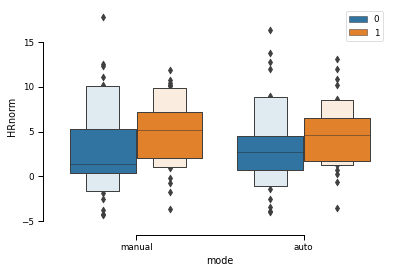

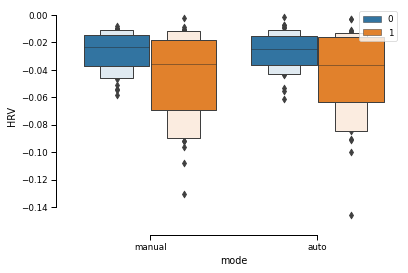

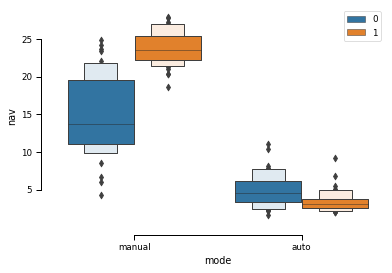

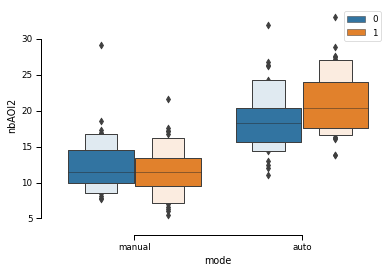

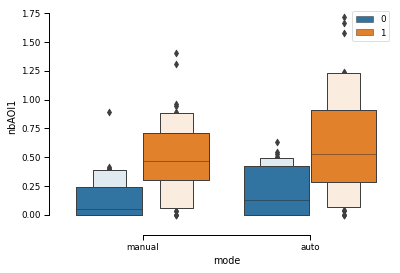

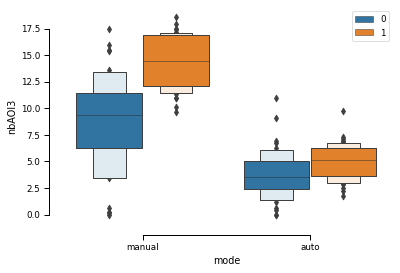

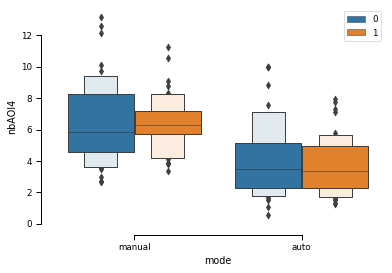

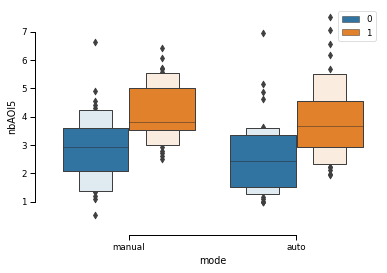

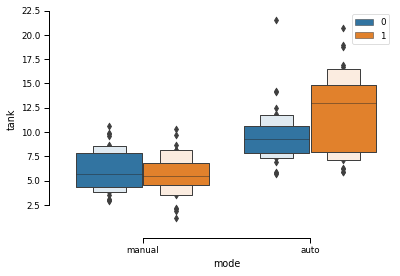

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

######################################################################
### Defining some useful plotting function for you
def plotting_data_per_mode(data, xstr, ystr):
    palette=sorted(sns.color_palette("BuGn", 10), reverse=True)
    palette = [palette[6], palette[9]]
    sns.set_context("paper", font_scale=1, rc={"lines.linewidth": 2.5})
    sns.boxenplot(x=xstr, y=ystr, hue="mode", palette=palette, linewidth=1, data=dfaveraged_data)
    #plt.ylim([-1, 30])
    plt.xticks([0, 1], ['low scores group', 'high scores group'])
    sns.despine(offset=10, trim=True)
    plt.legend(loc='best')
    
def plotting_data_per_perfgroup(data, xstr, ystr):
    palette=sorted(sns.color_palette("BuGn", 10), reverse=True)
    palette = [palette[6], palette[9]]
    sns.set_context("paper", font_scale=1, rc={"lines.linewidth": 2.5})
    #sns.boxenplot(x=xstr, y=ystr, hue="label", palette=palette, linewidth=1, data=dfaveraged_data)
    sns.boxenplot(x=xstr, y=ystr, hue="label", linewidth=1, data=dfaveraged_data)
    #plt.ylim([-1, 30])
    plt.xticks([0, 1], ['manual', 'auto'])
    sns.despine(offset=10, trim=True)
    plt.legend(loc='best')
    plt.show()
    

#######################################################################
# importing data
dfaveraged_data = pd.read_csv('./averagedPMPVmode_w10_data.csv')

## Plotting display examples
## Note these plots represent quantiles of the quantitative variables
## plotting operation mode x HRnorm grouped by the performance label
plotting_data_per_perfgroup(dfaveraged_data, "mode", "HRnorm")
plt.show()
#plt.clf()

## plotting operation mode x HRV grouped by the performance label
plotting_data_per_perfgroup(dfaveraged_data, "mode", "HRV")
plt.show()
#plt.clf()

## plotting operation mode x nav keystrokes grouped by the performance label
plotting_data_per_perfgroup(dfaveraged_data, "mode", "nav")
plt.show()
#plt.clf()

## plotting operation mode x nbAOI2 keystrokes grouped by the performance label
plotting_data_per_perfgroup(dfaveraged_data, "mode", "nbAOI2")
plt.show()
#plt.clf()


### PLEASE CONTINUE DESCRIPTIVE STATISTICAL ANALYSIS
## use summary statistics from scipy.stats library  

## plotting operation mode x nbAOI1 keystrokes grouped by the performance label
plotting_data_per_perfgroup(dfaveraged_data, "mode", "nbAOI1")
plt.show()
#plt.clf()

## plotting operation mode x nbAOI3 keystrokes grouped by the performance label
plotting_data_per_perfgroup(dfaveraged_data, "mode", "nbAOI3")
plt.show()
#plt.clf()
 
## plotting operation mode x nbAOI4 keystrokes grouped by the performance label
plotting_data_per_perfgroup(dfaveraged_data, "mode", "nbAOI4")
plt.show()
#plt.clf()   

## plotting operation mode x nbAOI5 keystrokes grouped by the performance label
plotting_data_per_perfgroup(dfaveraged_data, "mode", "nbAOI5")
plt.show()
#plt.clf()


## plotting operation mode x tank keystrokes grouped by the performance label
plotting_data_per_perfgroup(dfaveraged_data, "mode", "tank")
plt.show()
#plt.clf()

                                     


#### Draw conclusions for task 1.1.1 here:


Answer: Les marqueurs les plus pertinents pour entrainer notre classifieur sont ceux qui présentent des valeurs significativement différentes entre les groupes de bonnes performances et de basses performances.
Concernant l'impact du mode de jeu (manuel ou auto), son importance est moindre car la performance globale du joueur est reflétée en mode manuel.
Par conséquent, au vu des médianes et des écarts types obtenus pour chaque marqueur moyenné, nous choisissons dans un premier temps les marqueurs nav, nbAOI1, nbAOI3 et nbAOI5.

**Task 1.1.2: Statistical analysis**

To achieve this task, get a look on the data, and answer the following questions
* **Which are the markers significantly impacted by the human operator perf/engagement (POMDP observation)?**
* **Are the markers also impacted by the robot operation mode (POMDP action)?**

**For that, you have to formally define the null hypothesis (H0) and the alternative one (H1) for each statistical test**

**Remark 1 :** make use of ***Introduction to Statistics for Experimentations*** course (DNIA302) to achieve this step.

**Remark 2 :** note that the **averaged data file (averagedPMPVmode_w10_data) will be used for this analysis**. The 10-second time window data is averaged by participant, mission and operation mode. Additional columns appear, providing the total number of trees extinguished for each operation mode, as well as the performance/engagement label.

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Index(['HR', 'HRV', 'HRnorm', 'durAOI1', 'durAOI2', 'durAOI3', 'durAOI4',
       'durAOI5', 'mission', 'mode', 'nav', 'nbAOI1', 'nbAOI2', 'nbAOI3',
       'nbAOI4', 'nbAOI5', 'space', 'subject', 'tank', 'tank_local_score',
       'trees', 'nbt_trees_mode', 'label', 'modeperf', 'submission'],
      dtype='object')
#####################################################################
2-WAY ANOVA H1: HRV is impacted by the operation mode and the performance (label)
Overall model F( 3, 140) =  5.830, p =  0.0009

                            OLS Regression Results                            
Dep. Variable:                    HRV   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     5.830
Date:                Wed, 09 Feb 2022   Prob (F-statistic):           0.000879
Time:                        13:41:32   Log-Likelihood:                 325.64
No. Observa

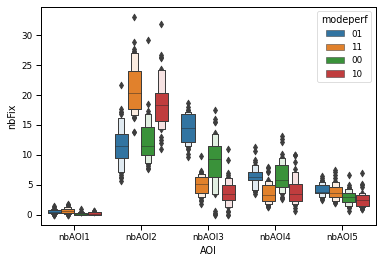

                 Anova
         F Value  Num DF  Den DF  Pr > F
----------------------------------------
AOI      614.6561 4.0000 284.0000 0.0000
mode       0.0538 1.0000  71.0000 0.8172
AOI:mode 310.0612 4.0000 284.0000 0.0000

#####################################################################
3-WAY ANOVA H1: durFix is impacted by the AOI, the operation mode and the performance (label)
                               sum_sq     df           F         PR(>F)
Intercept                2.183388e+04    1.0    0.061067   8.048903e-01
C(mode)                  4.191383e+03    1.0    0.011723   9.138111e-01
C(label)                 9.370909e+04    1.0    0.262093   6.088475e-01
C(AOI)                   3.062833e+08    4.0  214.159174  6.392899e-120
C(mode):C(label)         5.507587e+02    1.0    0.001540   9.687039e-01
C(mode):C(AOI)           1.110887e+08    4.0   77.675348   1.592641e-54
C(label):C(AOI)          3.343879e+07    4.0   23.381042   3.665160e-18
C(mode):C(label):C(AOI)  1.0656

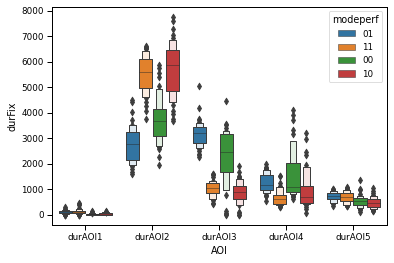

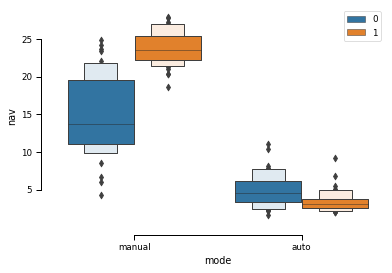

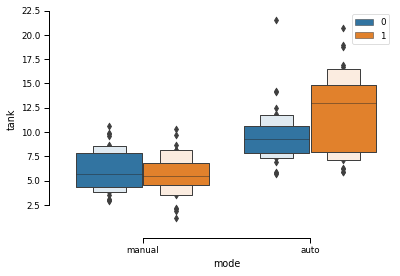

In [7]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.anova import AnovaRM
from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.stats.multicomp import MultiComparison, pairwise_tukeyhsd, tukeyhsd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

#########################
# Importing data
dfaveraged_data = pd.read_csv('./averagedPMPVmode_w10_data.csv')
#########################
# Creating groups "mode x label" for multiple comparison purposes 
dfaveraged_data['modeperf'] = dfaveraged_data['mode'].map(str) + dfaveraged_data['label'].map(str)
dfaveraged_data['submission'] = dfaveraged_data['subject'].map(str) + "_" + dfaveraged_data['mission'].map(str)
print(dfaveraged_data.columns)

#########################
# EXAMPLE 
# ANOVA considering performance group and robot operation mode
# NOTE: we have to assume that each mission is independent here because 
# some participants belong only to one performance group
# (in reality intra-subject sample are dependent)

# 1) We try to verify the hypothesis :
# H0 : HRV is not impacted by the operation mode nor the performance group (label)
# H1 : HRV is impacted by the operation mode or the performance group (label)
print("#####################################################################")
print("2-WAY ANOVA H1: HRV is impacted by the operation mode and the performance (label)")
HRVmodel = ols('HRV ~ C(mode)*C(label)', dfaveraged_data).fit()
print(f"Overall model F({HRVmodel.df_model: .0f},{HRVmodel.df_resid: .0f}) = {HRVmodel.fvalue: .3f}, p = {HRVmodel.f_pvalue: .4f}")
print()
print(HRVmodel.summary())
res = sm.stats.anova_lm(HRVmodel, typ= 2)
print()
print(res)

# perform multiple comparison (post-hoc Tukey HSD)
m_comp = MultiComparison(dfaveraged_data['HRV'], groups=dfaveraged_data['modeperf']).tukeyhsd(alpha=0.05)
print(m_comp)

##################################################
### PLEASE DO THE SAME ANALYSIS WITH HR JUST BELOW

# H0 : HR is not impacted by the operation mode nor the performance group (label)
# H1 : HR is impacted by the operation mode or the performance group (label)
print("#####################################################################")
print("2-WAY ANOVA H1: HR is impacted by the operation mode and the performance (label)")
HRmodel = ols('HR ~ C(mode)*C(label)', dfaveraged_data).fit()
print(f"Overall model F({HRmodel.df_model: .0f},{HRmodel.df_resid: .0f}) = {HRmodel.fvalue: .3f}, p = {HRmodel.f_pvalue: .4f}")
print()
print(HRmodel.summary())
res1 = sm.stats.anova_lm(HRmodel, typ= 2)
print()
print(res1)

# perform multiple comparison (post-hoc Tukey HSD)
m_comp1 = MultiComparison(dfaveraged_data['HR'], groups=dfaveraged_data['modeperf']).tukeyhsd(alpha=0.05)
print(m_comp1)



#################################################################
### NOW LET'S ANALYSE THE NUMBER OF FIXATIONS IN AOIs (nbFixAOIX)
# for instance:
# 2a) We try to verify the hypothesis : 
# H0 : the number of fixations is not affected by the AOI index nor the operation mode
# H1 : the number of fixations is affected by the AOI index or the operation mode
df = pd.melt(dfaveraged_data[["modeperf","mode","label","submission","subject","nbAOI1","nbAOI2","nbAOI3","nbAOI4","nbAOI5"]], 
             id_vars=["modeperf","submission","mode","label","subject"], 
             value_vars=["nbAOI1","nbAOI2","nbAOI3","nbAOI4","nbAOI5"])
df = df.rename(columns={'value': 'nbFix'})
df = df.rename(columns={'variable': 'AOI'})

# NOTE: we use a repeated measures ANOVA design because data is dependent within subjects and missions
res=AnovaRM(data=df,depvar="nbFix",subject="submission", within=["AOI","mode"]).fit()
print(res)

# 2b) We try to verify the hypothesis : 
# H0 : the number of fixations is not affected by the AOI index nor the operation mode nor the performance label
# H1 : the number of fixations is affected by the AOI index or the operation mode or the performance label
# NOTE: we can't use repeated measure ANOVA design in this case because:
# all the conditions aren't repeated within subjects
sns.boxenplot(x="AOI", y="nbFix", hue="modeperf", linewidth=1, data=df)
print("#####################################################################")
print("3-WAY ANOVA H1: nbFix is impacted by the AOI, the operation mode and the performance (label)")
nbFixModel = ols('nbFix ~ C(mode)*C(label)*C(AOI)', df).fit()
res = sm.stats.anova_lm(nbFixModel, typ= 3)
print(res)

# perform multiple comparison (post-hoc Tukey HSD)
df['modeperfAOI'] = df['mode'].map(str) + "_" + df['label'].map(str) + "_" + df['AOI'].map(str)
m_comp_crossAOIs = MultiComparison(df['nbFix'], groups=df['modeperfAOI']).tukeyhsd(alpha=0.05)
print(m_comp_crossAOIs)
plt.show()

###########################################################################
### PLEASE DO THE SAME ANALYSIS WITH THE AOIs FIXATION DURATIONS JUST BELOW

# 3a) We try to verify the hypothesis : 
# H0 : the AOIs fixation duration is not affected by the AOI index nor the operation mode
# H1 : the AOIs fixation duration is affected by the AOI index or the operation mode
df1 = pd.melt(dfaveraged_data[["modeperf","mode","label","submission","subject","durAOI1","durAOI2","durAOI3","durAOI4","durAOI5"]], 
             id_vars=["modeperf","submission","mode","label","subject"], 
             value_vars=["durAOI1","durAOI2","durAOI3","durAOI4","durAOI5"])
df1 = df1.rename(columns={'value': 'durFix'})
df1 = df1.rename(columns={'variable': 'AOI'})

# NOTE: we use a repeated measures ANOVA design because data is dependent within subjects and missions
res2=AnovaRM(data=df1,depvar="durFix",subject="submission", within=["AOI","mode"]).fit()
print(res2)

# 3b) We try to verify the hypothesis : 
# H0 : the number of fixations is not affected by the AOI index nor the operation mode nor the performance label
# H1 : the number of fixations is affected by the AOI index or the operation mode or the performance label
# NOTE: we can't use repeated measure ANOVA design in this case because:
# all the conditions aren't repeated within subjects
sns.boxenplot(x="AOI", y="durFix", hue="modeperf", linewidth=1, data=df1)
print("#####################################################################")
print("3-WAY ANOVA H1: durFix is impacted by the AOI, the operation mode and the performance (label)")
durFixModel = ols('durFix ~ C(mode)*C(label)*C(AOI)', df1).fit()
res2 = sm.stats.anova_lm(durFixModel, typ= 3)
print(res2)

# perform multiple comparison (post-hoc Tukey HSD)
df1['modeperfAOI'] = df1['mode'].map(str) + "_" + df1['label'].map(str) + "_" + df1['AOI'].map(str)
m_comp_crossAOIs2 = MultiComparison(df1['durFix'], groups=df1['modeperfAOI']).tukeyhsd(alpha=0.05)
print(m_comp_crossAOIs2)
plt.show()


####################################################################################
### PLEASE DO THE SAME ANALYSIS WITH THE KEYSTROKES AND CLICKS (nav,tank) JUST BELOW

## plotting operation mode x nav keystrokes grouped by the performance label
plotting_data_per_perfgroup(dfaveraged_data, "mode", "nav")
plt.show()
#plt.clf()

## plotting operation mode x tank keystrokes grouped by the performance label
plotting_data_per_perfgroup(dfaveraged_data, "mode", "tank")
plt.show()
#plt.clf()


#### Draw your conclusions for the task 1.1.2 here:

Answer: Lors de la question précédente, nous avions déjà remarqué que les marqueurs nav, nbAOI1, nbAOI3 et nbAOI5 étaient impactés par la performance du joueur. L'analyse ci-dessus nous permet de déterminer en plus dans quelle mesure les durées de fixation sur les AOIs sont impactées par la performance du joueur.
Ainsi, les durées de fixation sur les AOI2 et AOI3 sont impactés par les performances du joueur.

**Task 1.1.3: Based on the results obtained above, define the subdataset to be considered for classification**

**Remark 1 :** note that the data file *df10labeled_data* will be used in this exercise, where all 10-second time windows are listed. The goal here is to produce a prediction for each sample built on a 10-second time window

In [8]:
import pandas as pd
import numpy as np

#########################################################
# importing data
df10labeled_data = pd.read_csv('./df10labeled_data.csv')
print(df10labeled_data)

#########################################################
## Next, we propose to remove  data samples related to some subjects from the training data set:
## note that it allows to verify that the framework is working with new subjects never used for 
## learning POMDP parameters.

## EXAMPLE: we exclude here subjects 19, 23, 33 and 38
subdf10labeled_data = df10labeled_data.loc[(df10labeled_data["subject"]!=19)&
                                           (df10labeled_data["subject"]!=23)&
                                           (df10labeled_data["subject"]!=33)&
                                           (df10labeled_data["subject"]!=40)]
print(subdf10labeled_data)

##########################################################
## EXAMPLE of feature selection 
## please select features according to your previous statistical analysis !!
subdataset = subdf10labeled_data.loc[:, ['nav',  
                                      'nbAOI1',  
                                      'nbAOI3',  
                                      'nbAOI5',
                                      'durAOI2',
                                      'durAOI3',   
                                      'label']]

print(subdataset)

      subject  mission  mode  ...  tank_local_score    HRnorm  label
0        19.0      1.0   0.0  ...             0.000  6.185203    1.0
1        19.0      1.0   0.0  ...            -2.222  7.846128    1.0
2        19.0      1.0   1.0  ...            -8.445  6.921088    1.0
3        19.0      1.0   1.0  ...             4.555  3.578949    1.0
4        19.0      1.0   1.0  ...            19.032  4.387671    1.0
...       ...      ...   ...  ...               ...       ...    ...
3586     40.0      4.0   1.0  ...             7.286  3.992174    0.0
3587     40.0      4.0   0.0  ...             2.714  1.271330    0.0
3588     40.0      4.0   0.0  ...             3.778  3.773822    0.0
3589     40.0      4.0   0.0  ...            -0.334  6.470367    0.0
3590     40.0      4.0   1.0  ...            -1.111  5.789618    0.0

[3591 rows x 22 columns]
      subject  mission  mode  ...  tank_local_score     HRnorm  label
232      20.0      1.0   0.0  ...            14.571   1.744660    0.0
233   

**Task 1.1.4 Classifier Setup**

The goal here is to find the best classifier (i.e. the most accurate) to predict the human operator's mental state.

Thus, we propose to:
1. split the dataset into training and testing sets
2. choose a classifier according to the sklearn map (https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)
2. define a pipeline (https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)
3. select the hyper-paremeters to be cross-validated as well as the associated candidates for each hyper-parameter
4. define the grid-search cross-validation classifier
5. train it using the fit method on the training set
6. evaluate the resulting classifier on the testing set
7. go back to step 2



In [9]:
#### PLEASE PUT YOUR CODE HERE

### import libraries

from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.colors import ListedColormap

from sklearn.utils import all_estimators
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV
#from sklearn.grid_search import GridSearchCV

### split dataset into training and testing sets


v = subdataset.values
X = v[:, 0:5]
y = v[:,-1]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)



### define classifier

# Nous avons entraîné trois classifieurs différents pour comparer leurs scores sur notre jeu de données. 
# Sans optimisation des paramètres des classifieurs, adaBoost est le plus performant.

clf1 = SVC()

clf2 = GaussianProcessClassifier (1.0 * RBF(1.0))
clf3 = AdaBoostClassifier()

#clf1.fit(X_train, y_train)
#clf2.fit(X_train, y_train)
#clf3.fit(X_train, y_train)

#score1 = clf1.score(X_test, y_test)
#score2 = clf2.score(X_test, y_test)
#score3 = clf3.score(X_test, y_test)

#print("Score SVC: ", score1)
#print("Score Gaussian: ", score2)
#print("Score Ada : ", score3)




####### !!!!!! Utiliser adaboost plutot que SVC qui est trop lent !!!!!!!!!!!!!!!!!!!!!!!!


### define pipeline

### define hyper-parameters and associated candidates

print("Available meta-parameters: ", clf3.get_params().keys())

#meta_parameters = {
    #'kernel': ['linear', 'rbf'],
    #'C': [0.1,1,10]
#}

meta_parameters = {#"base_estimator" : ["gini", "entropy"],
              #"base_estimator" :   ["best", "random"],
              "n_estimators": [1, 2,3,15,20,30]
             }

opt_clf3 = GridSearchCV(clf3, meta_parameters, scoring = 'roc_auc')



opt_clf3.fit(X_train, y_train)
print("Best parameters: ", opt_clf3.best_params_)

score3opt = opt_clf3.score(X_test, y_test)
print("Score 3 opt: ", score3opt)

### define the grid search cross-validation classifier



### train using the fit method


### evaluate the classifier and print results

from sklearn.metrics import confusion_matrix
y_pred = opt_clf3.predict(X_test)

print(classification_report(y_test, y_pred))

Available meta-parameters:  dict_keys(['algorithm', 'base_estimator', 'learning_rate', 'n_estimators', 'random_state'])
Best parameters:  {'n_estimators': 30}
Score 3 opt:  0.7129880132553202
              precision    recall  f1-score   support

         0.0       0.62      0.51      0.56       496
         1.0       0.66      0.75      0.70       623

    accuracy                           0.65      1119
   macro avg       0.64      0.63      0.63      1119
weighted avg       0.65      0.65      0.64      1119


**Task 1.1.5: Extract the confusion matrix of your classifier**

**Remark 1 :** use the notions learnt in the Machine Learning introduction lecture



In [10]:
## Extract the confusion matrix of your classifier here

#y_pred=y_pred[:len(y_pred)-1]
Mconf = confusion_matrix(y_test, y_pred)
print(Mconf)

[[255 241]
 [153 470]]


**Task 1.1.6: Based on the confusion matrix, please formalize your POMDP observation function hereafter:**

Answer : $Pr(o' \mid s', a) = o(a,s',o')
= \begin{bmatrix} Pr(oe \mid e) & Pr(one \mid e) \\ Pr(one \mid ne) & Pr(oe \mid ne) \end{bmatrix}
= \begin{bmatrix} TPR & FPR \\ FNR & TNR \end{bmatrix}
= \begin{bmatrix} \Phi_{00} & \Phi_{01} \\ \Phi_{10} & \Phi_{11} \end{bmatrix}$,
$\forall a \in A$, 

and with
$\Phi_{00} = ?? $, $\Phi_{01} = ?? $, $\Phi_{10} = ?? $, and $\Phi_{11} = ?? $.


In [11]:
tot1 = sum(Mconf[0,:])
tot2 = sum(Mconf[1,:])

obsfunc = np.zeros((2,2))
obsfunc[0,0] = Mconf[0,0]/tot1
obsfunc[0,1] = Mconf[0,1]/tot1
obsfunc[1,0] = Mconf[1,0]/tot2
obsfunc[1,1] = Mconf[1,1]/tot2

obsfunc

array([[0.5141129 , 0.4858871 ],
       [0.24558587, 0.75441413]])

### Task 1.2 : Define the POMDP reward function

An optimal policy maximizes the sum of rewards over time. 
The reward function therefore defines the criterion that the artificial agent seeks to optimize. 
Here we would like to define this reward function.

Since the goal of the task is to put out as many fires as possible,
the reward should be defined as the number of tree extinguished
during the 10-second time window denoted by $R_t$: the value function is then:

$ V = \mathbb{E}\big[ \sum_t R_t \big]
= \mathbb{E} \Big[ \sum_t  \mathbb{E} \big[ R_t \mid s_t, a_t \big] \Big]
= \mathbb{E} \Big[ \sum_t  r(s_t, a_t) \Big]$,

where, $r(s,a) = \mathbb{E} \big[ R_t \mid s_t=s, a_t=a \big]$
is the expectation of the reward given the system state and the agent action,
that could be defined as the reward function.

These expectations ($\forall (s,a) \in S \times A)$ can be easily approximated using the dataset,
and the resulting averages can then be used to define the reward function in practice.
To this end, it is important to analyse again our averaged dataset. 


**1.2.1. Given the state and action spaces defined above, please formalize your reward function:**


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

##################################################
## importing data
dfaveraged_data = pd.read_csv('./averagedPMPVmode_w10_data.csv')

##################################################
## excluding the same participants as before
subdfaveraged_data = dfaveraged_data.loc[(dfaveraged_data["subject"]!=19)&
                                           (dfaveraged_data["subject"]!=23)&
                                           (dfaveraged_data["subject"]!=33)&
                                           (dfaveraged_data["subject"]!=40)]
print (subdfaveraged_data)

##################################################
### PLEASE proceed with computations of the four (4) reward function values
### Remind that expectations can be easily approximated using the dataset, 
### and the resulting averages can then be used to define the reward function in practice.

#2 états : engagé, désengagé
#actions : manuel, auto
#fonction de reward : matrice 2*2


#Reward function
R = np.zeros((2,2))


mode = dfaveraged_data['mode'].tolist()
trees = dfaveraged_data['trees'].tolist()
label = dfaveraged_data['label'].tolist()



countME =0
countAE=0
countMNE=0
countANE=0

#On décompte le nombre d'arbres éteints pour chaque couple (action, état)

for k in range(len(mode)):
    if mode[k]==0 and label[k]==1:
        R[0,0]+=trees[k]
        countME+=1
    if mode[k]==0 and label[k]==0:
         R[0,1]+=trees[k]
         countMNE+=1
    if mode[k]==1 and label[k]==1:
         R[1,0]+=trees[k]
         countAE+=1
    if mode[k]==1 and label[k]==0:
         R[1,1]+=trees[k]
         countANE+=1
        
#Puis on fait la moyenne

R[0,0]=R[0,0]/countME
R[0,1]=R[0,1]/countMNE
R[1,0]=R[1,0]/countAE
R[1,1]=R[1,1]/countANE



print(R)



            HR       HRV     HRnorm  ...     trees  nbt_trees_mode  label
8    82.295194 -0.011808   2.285859  ...  0.473684               9      0
9    82.833853 -0.015138   2.824519  ...  0.400000               8      0
10   82.448589 -0.011103   2.301653  ...  0.518519              14      1
11   83.831082 -0.016444   3.684146  ...  0.406250              13      1
12   84.516933 -0.027626   8.905743  ...  0.533333              16      1
..         ...       ...        ...  ...       ...             ...    ...
131  77.796189 -0.084523  12.028904  ...  0.344828              10      1
132  79.965476 -0.054221  10.763638  ...  0.678571              19      1
133  80.086270 -0.048275  10.884432  ...  0.451613              14      1
134  80.606207 -0.075121  10.458897  ...  0.653846              17      1
135  80.395658 -0.063058  10.248348  ...  0.393939              13      1

[112 rows x 23 columns]
[[0.55484027 0.28190895]
 [0.41760041 0.35650864]]


**1.2.2. State a necessary condition on reward function to enable a non trivial POMDP optimization.**

For instance, what is the issue if r(s,manual) = r(s,auto) $\forall s \in S$

#Answer: Si r(s,manual) = r(s,auto) pour tout s, impossible de distinguer une bonne action d'une mauvaise : la stratégie adoptée sera donc aléatoire. 
Une condition nécessaire pour éviter une stratégie aléatoire est d'avoir r(s,manual) != r(s,auto) pour tout s. Ainsi, dans un état donné, l'algo peut distinguer la meilleure action à entreprendre.


**1.2.3. Verify with descriptive statistics that the reward function changes with respect to state and action.**

* **Is the score (number of extinguished trees) evolving differently with respect to the robot operation mode and human operator engagement (described by her/his mission performance)?**

[[0.55484027 0.28190895]
 [0.41760041 0.35650864]]


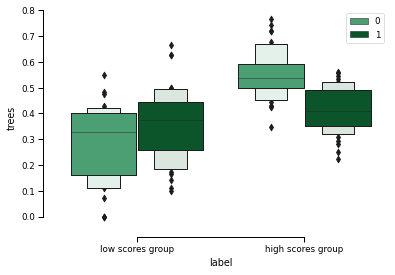

In [13]:
## get a look on how the number of fires extinguished  evolves
## in function of the operation mode and mission performance
## use plotting_data_per_mode function given in the begining of this notebook

# we can also plot the frequency (or the expected number)

#Réponse : 

print(R)
plotting_data_per_mode(dfaveraged_data, "label", "trees")

#La fonction de reward R codée en 1.2.1 montre que les récompenses évoluent en fonction de l'état et de l'action entreprise (les coefficients de la matrice étant tous différents).
#Cependant, on remarque que r(ne, manual)=6.22 est proche de r(ne, auto) ce qui, comme évoqué dans la question précédente, peut induire 
#une décision d'action relativement aléatoire dans le cas d'un étant non engagé.

#

**1.2.4. Please identify the greedy action $a \in A = \{manual, auto\}$ ("autonomous robot mode" or "manual mode") for each hidden system state $s \in S = \{e, ne\}$ ("engagement" or "no engagement").** 

Describe then the behavior of the artificial agent suggested by this reward function.

Answer:En s'intéressant à la première colonne de la matrice de reward, 16>12 donc dans un état engagé, la fonction tend à passer en manuel.
En s'intéressant à la seconde colonne de la matrice de reward, 7>6.22 donc dans un état désengagé, la fonction tend à passer en automatique.

## Task 2: POMDP model solving and evaluation

### Task 2.1: POMDP model description using the Cassandra format

In this task, please use the Cassandra format to decribe the POMDP model, in a way that the PyPOMDP library can interpret it and solve the problem.

You can use the tiger-2D problem located at *.PyPOMDP/pypomdp/environments/pomdp/Tiger-2D.POMDP* as an example.

Please save the created model in the same folder as the *Tiger-2D.POMDP*, and copy/paste your Cassandra file in the cell bellow:

Answer:

#### EXAMPLE : Firefighter POMDP problem description in Cassandra format 

# Firefighter robot POMDP description in Cassandra format




discount: 0.95

values: reward

states: notengaged engaged 

actions: manu auto

observations: onotengaged oengaged

start: 0.5 0.5

T: manu
0.98 0.02
0.02 0.98

T: auto
0.98 0.02
0.02 0.98

O: manu
0.4146 0.5854
0.1355 0.8645

O: auto
0.4146 0.5854
0.1355 0.8645


R: manu : oengaged : * : * 0.55484027

R: manu : onotengaged : * : * 0.28190895

R: auto : oengaged : * : * 0.41760041

R: auto : onotengaged : * : * 0.35650864




### Task 2.2: POMDP model solving using the customized PyPOMDP library 

To solve the problem using the PyPOMDP library, you need to open a new terminal in the same folder as your jupyter-notebook.

Then, go to the folder .PyPOMDP/pypomdp/ and launch the following command line:

**python main.py pbvi --env Firefighter-2D.POMDP --logfile logFIREpbvi --option offsolve**

where:

pbvi is the algorithm to be used

--env : gives the pomdp file name of your model

--logfile : save the traces of policy computation and simulation (only one simulation)

--option : offline or online solving, or simulate a policy file


*Note a file called **alphavecfile.policy** is created. Please save this file with a more explicit name.*

This file will be useful in the following steps.

### Task 2.3: POMDP model evaluation in simulation

To evaluate the value function and policy obtained, you need to go back to the terminal and launch the following command line:

**python main.py pbvi --env Firefighter-2D.POMDP --policyfile alphavecfile.policy --logfile logFIREpbvi --max_play 60 --option simulate --sim 500**


where:

pbvi is the used algorithm

--env : gives the pomdp file name of your model

--logfile : save the traces of policy computation and simulation (only one simulation)

--option simulate : simulate a policy using the model

--policyfile : your policy file, default: alphavecfile.policy

--max_play :  (60 steps = 10 minutes = 1 mission, following the the 10s-step time assumption)

*Note that you will find a file named **YEAR-MONTH-DAY-H-MIN-S** in the logFile folder ("logFIREpbvi" here). Please have a look at this file to follow the performed simulations. At the end of this file there is a vector with all total rewards observed during the different simulations.*

**Please copy and paste policy simulation average results hereafter (what appears in the terminal):**


Answer:
500 simulations played.
Exp total reward =  25.335703400000014
Std Exp total reward =  0.8725609162737235

### Task 2.4 : Quantitative and qualitative comparison with the random policy used during experiments

In the following, another preprocessed dataset is given: **averagedPMPV_data.csv.** This dataset includes the global_score reached by each participant for each mission.

#### Task 2.4.1: Quantitative comparison

1. Compute the average number of trees extinguished following the random policy used during the experiments
2. Compare this results with the observed results (total_rewards) at least 72 simulations of 60 steps (which is equivalent to 18 participants x 4 mission)
3. Perform a statistical test to verify if the value reached by the optimized policy is significatively greater.

**Remark**: we could also compute the expected value of a random policy on the POMDP model defined. To do this used the following command line:

**python main.py pbvi --env Firefighter-2D.POMDP --logfile logFIREpbvi --max_play 60 --option simulate --sim 500 --random_policy 1**

Note that this expected value can differs from the one obtained from dataset. Why?

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy.stats import ttest_ind

## Computing the average number of trees extinghuised following the random policy used during the experiments
#################################
# importing data
dfaveraged_data = pd.read_csv('./averagedPMPV_data.csv')
dfaveraged_data.columns
print("Avg. global scores from dataset : ", np.mean(dfaveraged_data["global_score"]))

##################################
### copy the total rewards observed on your 72 simulations here
pomdp_obs_ttrew = [ ]
print("Avg. global scores from simulations : ", np.mean(pomdp_obs_ttrew))

##################################
### perform a statistical test to check the hypothesis:
## H0 : the mean score from dataset is equal to the mean score obtained from policy simulations
## H1 : the mean score from dataset is different to the mean score obtained from policy simulations

### perform a second statistical test to check the hypothesis:
## H0 : the mean score from dataset is higher than the mean score obtained from policy simulations
## H1 : the mean score from dataset is not higher than the mean score obtained from policy simulations



Avg. global scores from dataset :  22.083333333333332
Avg. global scores from simulations :  nan


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


**Draw your conclusion here :** 

Answer:

### Task 2.4.2: Qualitative comparison by performing a replay with collected data

Save the classifier model you have designed. It will be used by a replay runner to rerun a mission.

Our goal is to : 
1. follow the predictor outputs (the POMDP observations)
2. visualize the belief state updates about the human operator's engagement
3. check and describe what the POMDP policy would do given the current belief state

***1. Save your the classifier model***

see https://scikit-learn.org/stable/modules/model_persistence.html

In [15]:
from joblib import dump, load

#########################################
# save the model named: classifier.joblib



Now, save this classifier.joblib file in "PyPOMDP/pypompd/data/" folder, and

***2. Run the replay program in the same terminal as before***

Note you may choose a subject file (one of the excluded participants for instance) to replay the experiment.

For that, see this command line example:

**python replay.py pbvi --env Firefighter-2D.POMDP --policyfile alphavecfile.policy --logfile logFIREpbvi --max_play 60 --option replay --sim 4 --expfile data/dfsub_33alldataproc.csv --classif YOUR_CLASSIFIER_MODEL --fnames THE_FEATURES_NAMES_YOU_USED**

where THE_FEATURES_NAMES_YOU_USED can be for instance 'mode,nav,tank,nbAOI1', and YOUR_CLASSIFIER_MODEL something like 'data/classifier.joblib'.
You may get a look in the log folder. 

The last logfile details the sequence of symbolic observations predicted from the selected features of the participant.

***3. Describe what the POMDP policy seems to do given the current belief state***

**Draw your conclusions here:**

Answer:

## Task 3 : Refining the POMDP model

### Refine the POMDP model to integrate a visible state variable $s_r$ to indicate the operation mode of the robot as part of the state

In this task, the aim is to expand the state spape $S$ such as: $S = S_h \times S_r$, with $S_h=\{e, ne\}$ and $S_r=\{manu,auto\}$, and to conditionnate the observation function with respect to the action taken.

1. If you observe the replay of experiences, how could you model the fact that when the robot operation mode changes, there is a bigger/lower chance the state of the human operator changes as well ?

2. If this fact is taken into account, it may changes the transition function. So, let's consider now two additionnal expert parameters $\beta$ and $\eta$ that will express the chance we have to obtain for instance : 
$$p(s'=(engaged,manual)|s=(engaged,auto),a=manual) = 1-\beta$$
$$p(s'=(notengaged,manual)|s=(engaged,auto),a=manual) = \beta$$
$$p(s'=(engaged,auto)|s=(engaged,manual),a=auto) = 1-\eta$$
$$p(s'=(notengaged,auto)|s=(engaged,manual),a=auto) = \eta$$

Note the transition function, now a $4x4$ matrix, need to be modified to integrate this new parameters. 

We will assume that the robot operation mode state variable has a deterministic dynamics. It means that when the action $auto$ is chosen, we are $100\%$ sure that the operation mode switches to $auto$.

If you have any problem with the grammar of the POMDP file description, please get a look at https://www.pomdp.org/code/pomdp-file-spec.html

3. Note, you can learn an observation function now conditionned on the action, to be able to integrate this new probabilities through belief state updates, i.e. : $b^o_a(s') \propto p(o|s',a)p(s'|s,a)b(s)$ 

4. Please revise some of the previous tasks in the cells bellow. 

### Task 3.1. Revise task 1.1.3 to separate your dataset in two datasets depending on the robot operation mode 

In [16]:
import pandas as pd
import numpy as np

##############################
# importing data
df10labeled_data = pd.read_csv('./df10labeled_data.csv')
print(df10labeled_data)

##############################
## excluding some subjects as before
## we empirically choose to exclude subjects 19, 23, 33, 38
subdf10labeled_data = df10labeled_data.loc[(df10labeled_data["subject"]!=19)&
                                           (df10labeled_data["subject"]!=23)&
                                           (df10labeled_data["subject"]!=33)&
                                           (df10labeled_data["subject"]!=38)]
print(subdf10labeled_data)

######################################################
# separate the dataset with respect to operation mode
# and select the features to be used for classification

subsubdataset_manu = ?

subsubdataset_auto = ?



SyntaxError: ignored

### Task 3.2. Revise tasks 1.1.4 and 1.1.5 to train a classifier per dataset and then, extract their confusion matrix

In [ ]:
#### PUT YOUR CODE HERE

### Task 3.3. Revise task 2.1 to define your POMDP in the Cassandra file format

Note you may probably have different transition and observations functions depending on the action manu/auto.

Copy and paste your POMDP model in Cassandra format hereafter:


### Firefighter.4D.POMDP

discount: 0.95

values: reward

states: notengagedmanu engagedmanu notengagedauto engagedauto 

actions: manu auto

observations: onotengaged oengaged

start: 0.25 0.25 0.25 0.25

...

### Task 3.4. Revise tasks 2.2 and 2.3

#### Copy and paste the used command lines for POMDP solving and the results obtained with 500 simulations for this new POMDP model and optimized policy


Answer:

## Champions' Question:

**Is this new POMDP model presenting a significant improvement according to the expected cumulated rewards when compared with the random policy used during experiments?**


**Is this new POMDP model presenting a significant improvement according to the expected cumulated rewards when compared with the policy optimized based on the previous POMDP model?**

Answer: